In [1]:
# Analyse broad assays based on their assay and readout types


In [2]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from scipy import stats
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef,confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

In [3]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

def check_heirarchial(assay, method, true, pred, prob):
    
    y_true = true
    y_pred = pred
    y_prob=  prob
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    #print(conf_matrix)
    
    #print(classification_report(y_true, y_pred))
    
    ba= balanced_accuracy_score(y_true, y_pred)
    #print('balanced_accuracy_score ',ba)
    
    mcc=matthews_corrcoef(y_true, y_pred)
    #print('matthews_corrcoef ',mcc)
    # Sensitivity, hit rate, recall, or true positive rate
    
    f1= f1_score(y_true, y_pred, average='binary')
    precision = precision_score(y_true, y_pred, average='binary')
    
    #print('F1 Toxic', f1)
    #print('precision', precision)
    
    Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    # Specificity or true negative rate
    Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
    
    #print( 'Sensitivity', Sensitivity)
    #print( 'Specificity', Specificity)
    AUC = roc_auc_score(y_true, y_prob)
    #print('AUC-ROC ',AUC)    
    # calculate roc curves
    best_model_fpr, best_model_tpr, _ = roc_curve(y_true, y_prob)   
    
    
    row=[assay, method, f1, precision, Sensitivity, Specificity, ba, mcc, AUC]
    metrics_list.append(row)
    
    return metrics_list

In [4]:
from sklearn.linear_model import LogisticRegression
from io import StringIO
import sys
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

In [5]:
metrics_list = pd.read_csv("All_metrics_merger_heirarchial.csv")
metrics_list

,assay,method,f1,precision,Sensitivity,Specificity,ba,mcc,AUC
0,178_684,CP,0.606061,0.526316,0.714286,0.780488,0.747387,0.453246,0.754355
1,178_684,Distance Based Merger,0.727273,0.631579,0.857143,0.829268,0.843206,0.628800,0.872822
2,178_684,Ensemble Averaged,0.583333,0.700000,0.500000,0.926829,0.713415,0.482063,0.713415
3,178_684,Heirarchial Model,0.620690,0.600000,0.642857,0.853659,0.748258,0.485639,0.789199
4,178_684,MFP,0.434783,0.555556,0.357143,0.902439,0.629791,0.305654,0.771777
...,...,...,...,...,...,...,...,...,...
440,93_259,CP,0.470588,0.400000,0.571429,0.684211,0.627820,0.233074,0.578947
441,93_259,Distance Based Merger,0.400000,0.666667,0.285714,0.947368,0.616541,0.323602,0.699248
442,93_259,Ensemble Averaged,0.444444,0.363636,0.571429,0.631579,0.601504,0.182262,0.601504
443,93_259,Heirarchial Model,0.400000,0.277778,0.714286,0.315789,0.515038,0.028904,0.586466


In [6]:
assay_desc=pd.read_csv("assaydesc.csv")
assay_desc.rename(columns={"PUMA_ASSAY_ID": "assay"}, inplace=True)
metrics_list = pd.merge(metrics_list, assay_desc)
metrics_list

,assay,method,f1,precision,Sensitivity,Specificity,ba,mcc,AUC,ASSAY_NAME,OBS_NAME,OBS_SOURCE,ASSAY_TYPE,READOUT_TYPE
0,178_684,CP,0.606061,0.526316,0.714286,0.780488,0.747387,0.453246,0.754355,178_684,178_684,178_684,cell,Luminescence
1,178_684,Distance Based Merger,0.727273,0.631579,0.857143,0.829268,0.843206,0.628800,0.872822,178_684,178_684,178_684,cell,Luminescence
2,178_684,Ensemble Averaged,0.583333,0.700000,0.500000,0.926829,0.713415,0.482063,0.713415,178_684,178_684,178_684,cell,Luminescence
3,178_684,Heirarchial Model,0.620690,0.600000,0.642857,0.853659,0.748258,0.485639,0.789199,178_684,178_684,178_684,cell,Luminescence
4,178_684,MFP,0.434783,0.555556,0.357143,0.902439,0.629791,0.305654,0.771777,178_684,178_684,178_684,cell,Luminescence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,93_259,CP,0.470588,0.400000,0.571429,0.684211,0.627820,0.233074,0.578947,HoxA13DNABinding.FluorOligo.HoxDNA,HoxA13,ChemBank,biochem,fluorescence
441,93_259,Distance Based Merger,0.400000,0.666667,0.285714,0.947368,0.616541,0.323602,0.699248,HoxA13DNABinding.FluorOligo.HoxDNA,HoxA13,ChemBank,biochem,fluorescence
442,93_259,Ensemble Averaged,0.444444,0.363636,0.571429,0.631579,0.601504,0.182262,0.601504,HoxA13DNABinding.FluorOligo.HoxDNA,HoxA13,ChemBank,biochem,fluorescence
443,93_259,Heirarchial Model,0.400000,0.277778,0.714286,0.315789,0.515038,0.028904,0.586466,HoxA13DNABinding.FluorOligo.HoxDNA,HoxA13,ChemBank,biochem,fluorescence


In [7]:
assay_compounds_stats_list = pd.read_csv("assay_compounds_stats_list_bothsideundersampling.csv")
assay_compounds_stats_list.rename(columns={"assay": "assay"}, inplace=True)
assay_compounds_stats_list

,assay,total,actives,inactives,ratio
0,178_684,272,68,204,0.250000
1,180_686,204,51,153,0.250000
2,183_604,180,45,135,0.250000
3,184_606,312,78,234,0.250000
4,185_665,120,30,90,0.250000
...,...,...,...,...,...
84,278_757,1508,377,1131,0.250000
85,279_758,264,66,198,0.250000
86,280_759,540,135,405,0.250000
87,283_762,428,107,321,0.250000


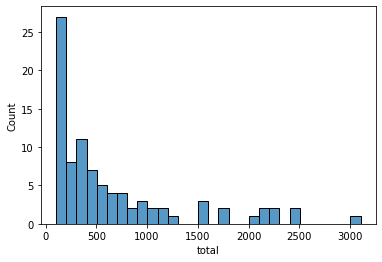

In [8]:
g= sns.histplot(data=assay_compounds_stats_list, x="total", binwidth=100)

In [9]:
#Relation between Model Performance and Label Data
metrics_list_compared_data = pd.merge(metrics_list, assay_compounds_stats_list, on="assay")
metrics_list_compared_data["ratio"] = metrics_list_compared_data["actives"]/metrics_list_compared_data["total"]
metrics_list_compared_data

,assay,method,f1,precision,Sensitivity,Specificity,ba,mcc,AUC,ASSAY_NAME,OBS_NAME,OBS_SOURCE,ASSAY_TYPE,READOUT_TYPE,total,actives,inactives,ratio
0,178_684,CP,0.606061,0.526316,0.714286,0.780488,0.747387,0.453246,0.754355,178_684,178_684,178_684,cell,Luminescence,272,68,204,0.250000
1,178_684,Distance Based Merger,0.727273,0.631579,0.857143,0.829268,0.843206,0.628800,0.872822,178_684,178_684,178_684,cell,Luminescence,272,68,204,0.250000
2,178_684,Ensemble Averaged,0.583333,0.700000,0.500000,0.926829,0.713415,0.482063,0.713415,178_684,178_684,178_684,cell,Luminescence,272,68,204,0.250000
3,178_684,Heirarchial Model,0.620690,0.600000,0.642857,0.853659,0.748258,0.485639,0.789199,178_684,178_684,178_684,cell,Luminescence,272,68,204,0.250000
4,178_684,MFP,0.434783,0.555556,0.357143,0.902439,0.629791,0.305654,0.771777,178_684,178_684,178_684,cell,Luminescence,272,68,204,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,93_259,CP,0.470588,0.400000,0.571429,0.684211,0.627820,0.233074,0.578947,HoxA13DNABinding.FluorOligo.HoxDNA,HoxA13,ChemBank,biochem,fluorescence,127,34,93,0.267717
441,93_259,Distance Based Merger,0.400000,0.666667,0.285714,0.947368,0.616541,0.323602,0.699248,HoxA13DNABinding.FluorOligo.HoxDNA,HoxA13,ChemBank,biochem,fluorescence,127,34,93,0.267717
442,93_259,Ensemble Averaged,0.444444,0.363636,0.571429,0.631579,0.601504,0.182262,0.601504,HoxA13DNABinding.FluorOligo.HoxDNA,HoxA13,ChemBank,biochem,fluorescence,127,34,93,0.267717
443,93_259,Heirarchial Model,0.400000,0.277778,0.714286,0.315789,0.515038,0.028904,0.586466,HoxA13DNABinding.FluorOligo.HoxDNA,HoxA13,ChemBank,biochem,fluorescence,127,34,93,0.267717


In [10]:
def return_values(method, metric):
    
    results_values = metrics_list_compared_data[metrics_list_compared_data["method"]==method][metric].values
    return(results_values)


In [11]:
df = pd.DataFrame()
df["CP_BA_values"] = return_values("CP", "ba")
df["MfP_BA_values"] = return_values("MFP", "ba")
df["Ensemble_Averaged_BA_values"] = return_values("Ensemble Averaged", "ba")
df["Heirarchial_BA_values"] = return_values("Heirarchial Model", "ba")
df["Distance_Based_Merger_BA_values"] = return_values("Distance Based Merger", "ba")
df["ASSAY_TYPE"]= metrics_list_compared_data[metrics_list_compared_data["method"]=="CP"]["ASSAY_TYPE"].values
df["READOUT_TYPE"]= metrics_list_compared_data[metrics_list_compared_data["method"]=="CP"]["READOUT_TYPE"].values
df

,CP_BA_values,MfP_BA_values,Ensemble_Averaged_BA_values,Heirarchial_BA_values,Distance_Based_Merger_BA_values,ASSAY_TYPE,READOUT_TYPE
0,0.747387,0.629791,0.713415,0.748258,0.843206,cell,Luminescence
1,0.717742,0.506452,0.651613,0.690323,0.785484,fungal,fluorescence
2,0.592593,0.666667,0.666667,0.537037,0.703704,cell,Luminescence
3,0.705452,0.853059,0.790559,0.831117,0.904255,cell,Luminescence
4,0.583333,0.611111,0.611111,0.527778,0.861111,biochem,qPCR
...,...,...,...,...,...,...,...
84,0.539266,0.705815,0.680881,0.712834,0.757357,cell,Luminescence
85,0.518269,0.760577,0.695192,0.648077,0.607692,cell,fluorescence
86,0.845679,0.629630,0.845679,0.839506,0.814815,bacterial,fluorescence
87,0.595971,0.461172,0.612088,0.361172,0.753114,biochem,fluorescence


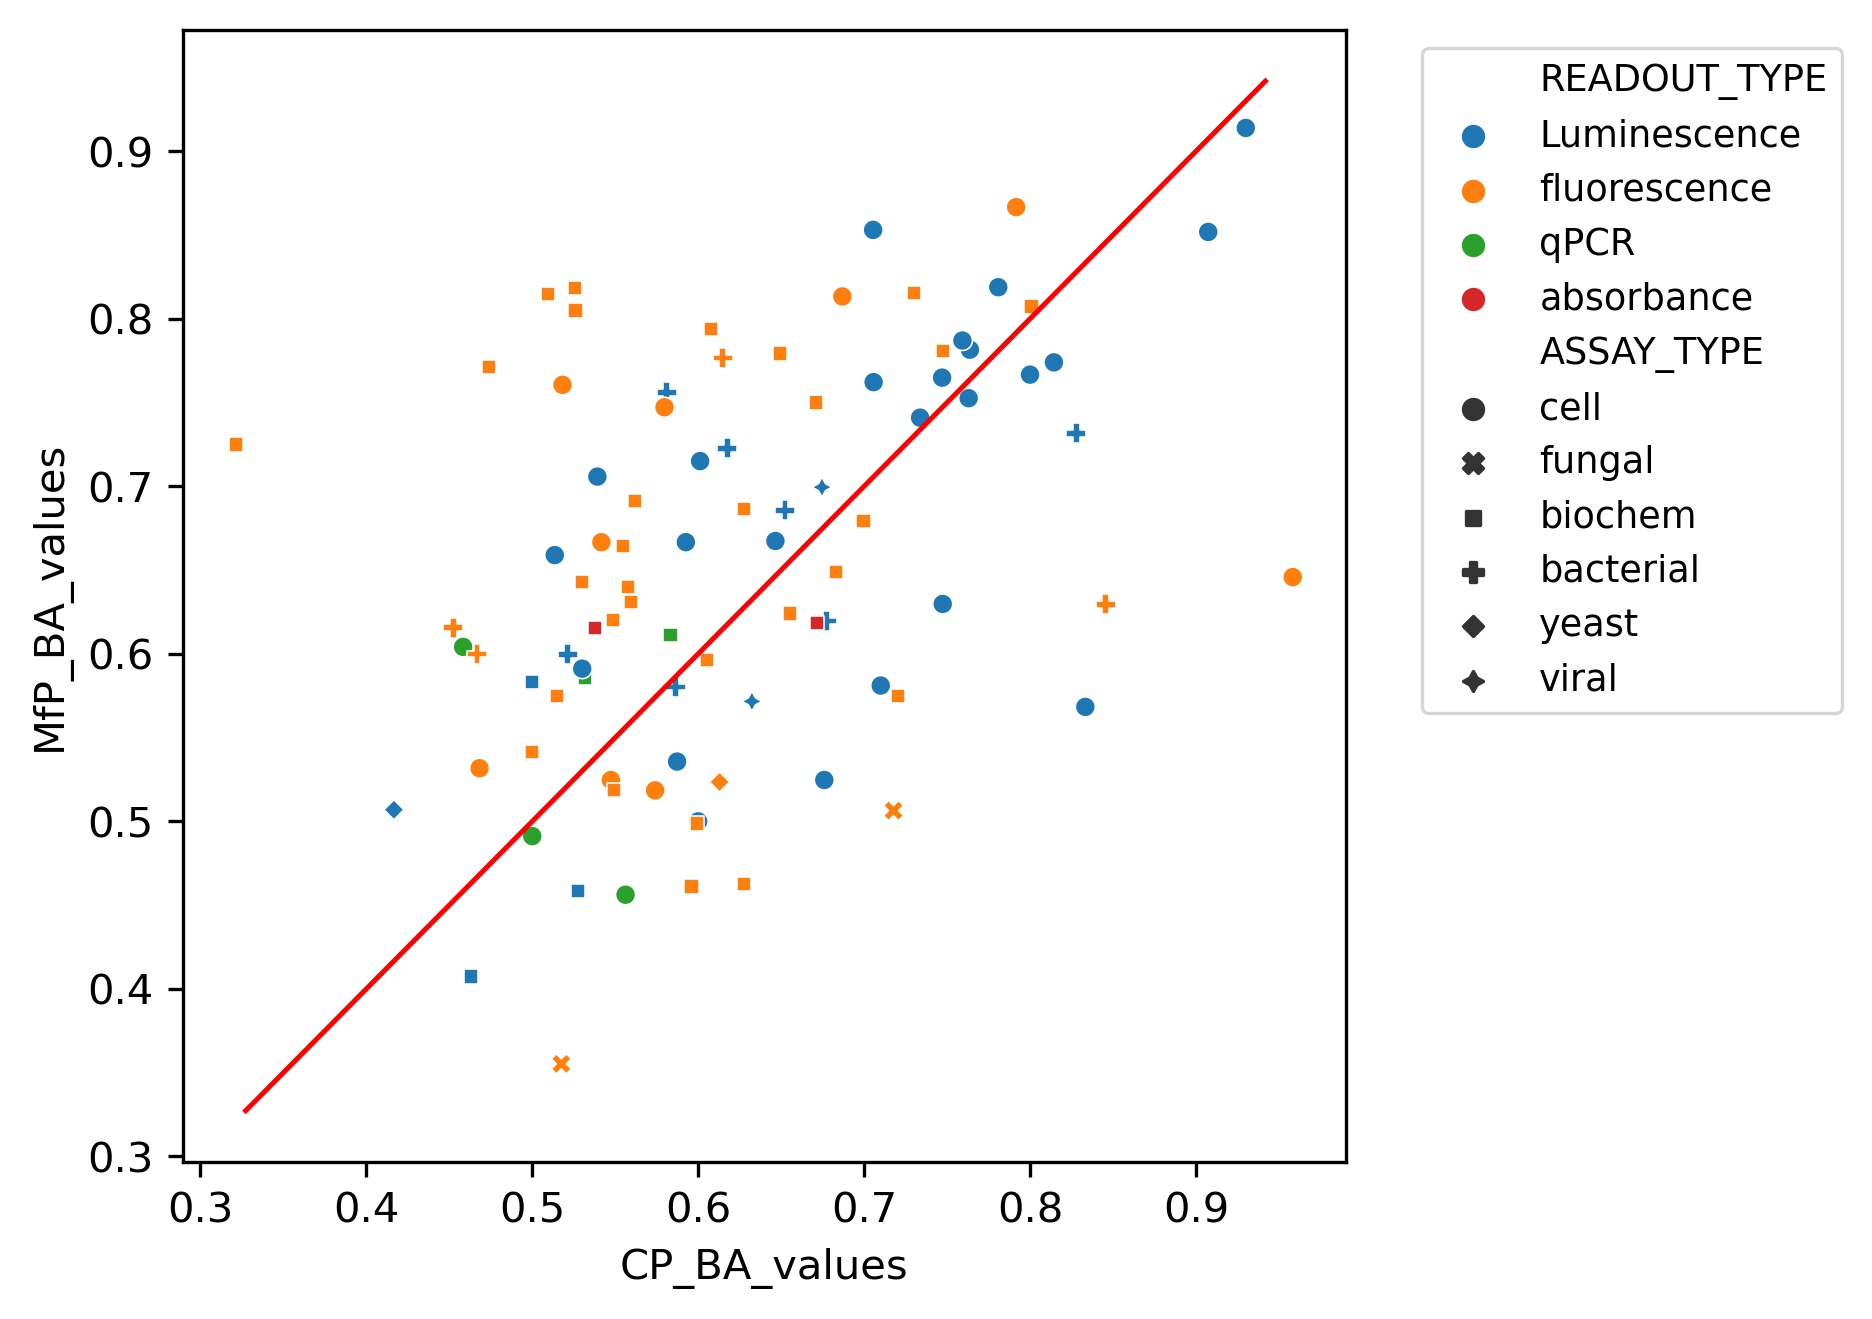

In [12]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
sns.set_context("paper")
g = sns.scatterplot(data=df, x="CP_BA_values", y="MfP_BA_values", hue="READOUT_TYPE", style="ASSAY_TYPE")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '-r')
plt.show()

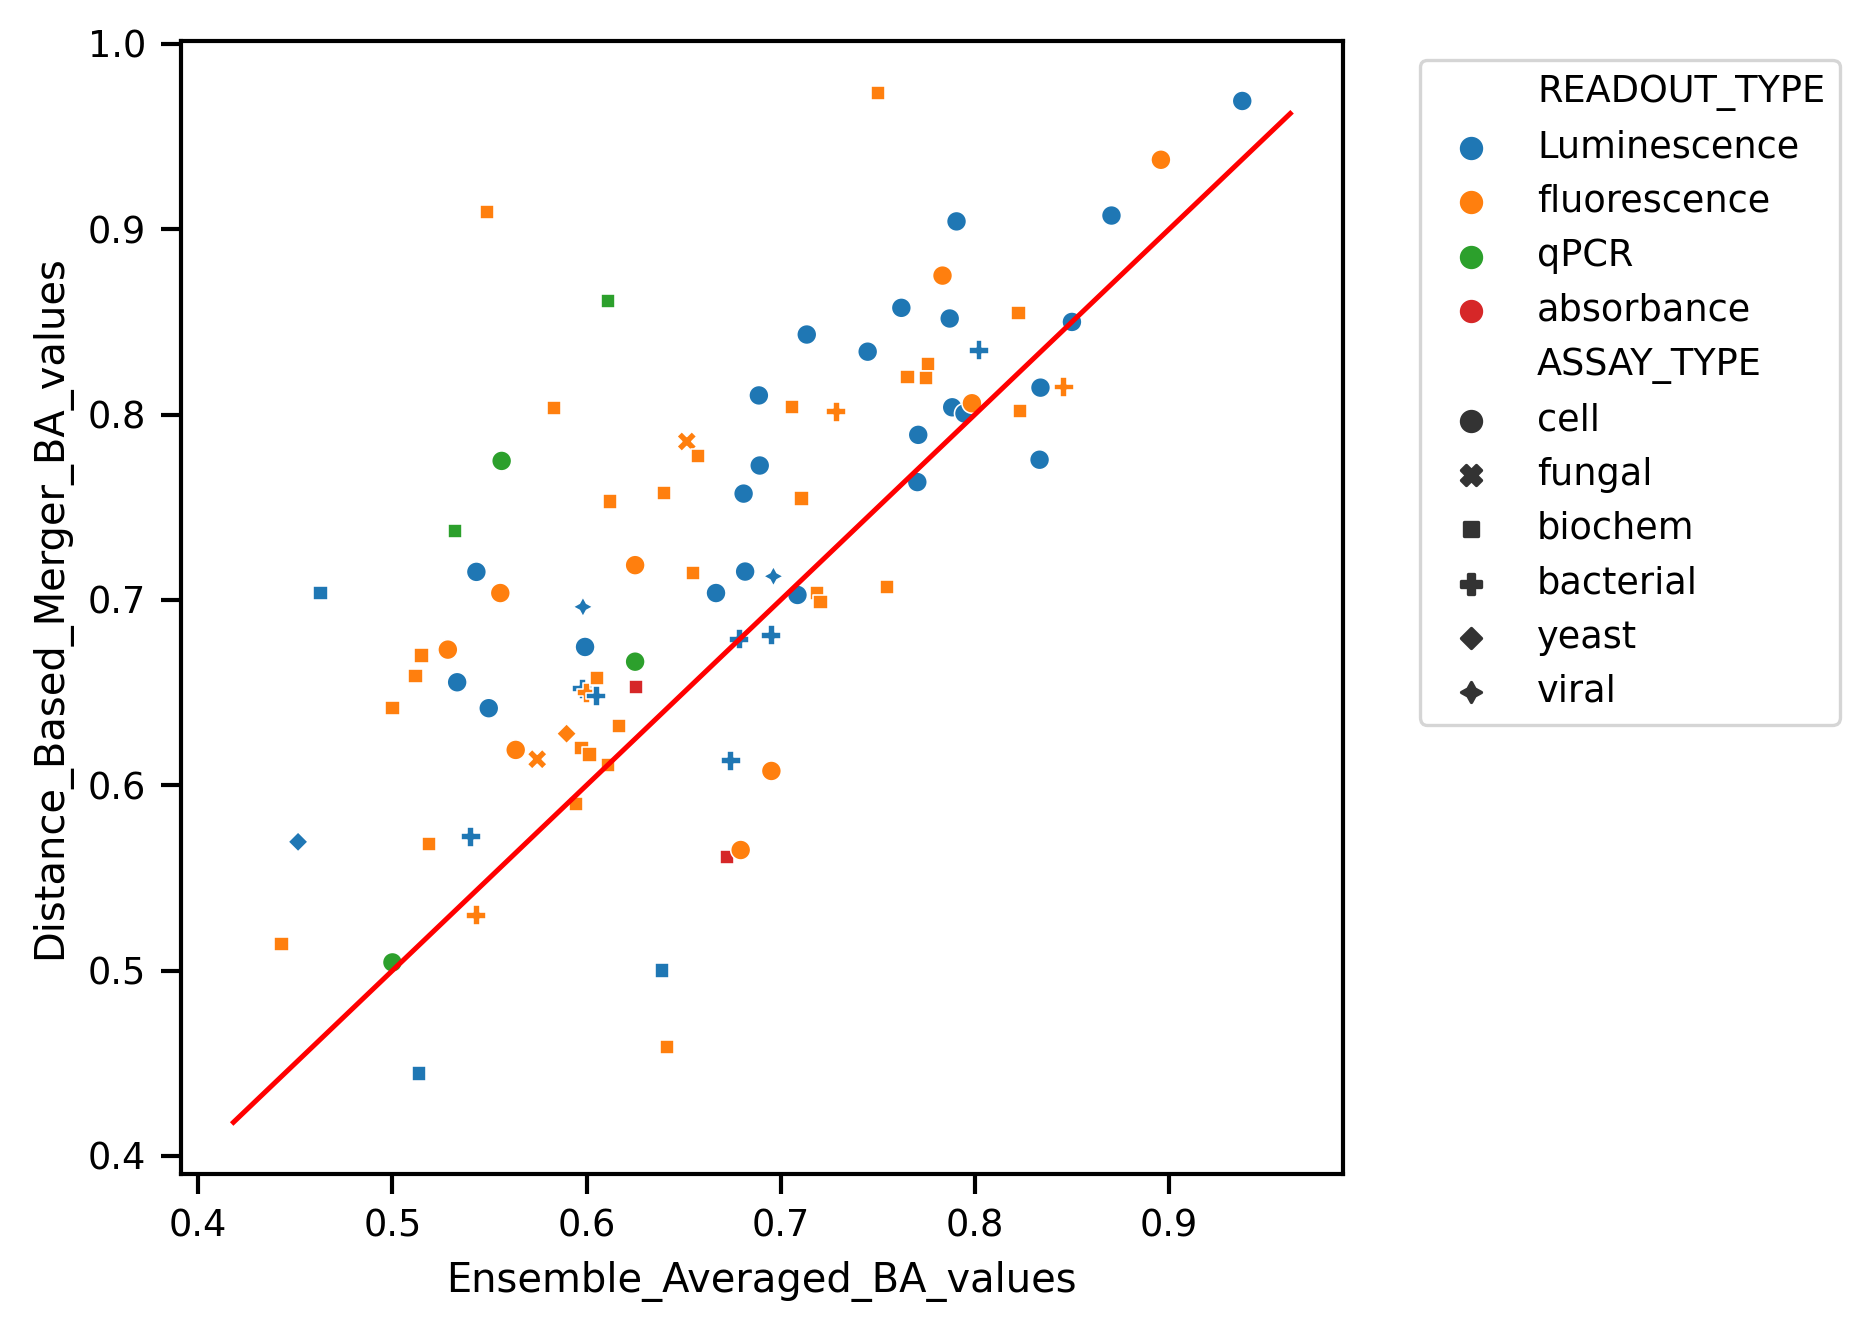

In [13]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
g  = sns.scatterplot(data=df, y="Distance_Based_Merger_BA_values", x="Ensemble_Averaged_BA_values", hue="READOUT_TYPE", style="ASSAY_TYPE")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '-r')
plt.show()

In [14]:
df_AUC = pd.DataFrame()
df_AUC["Cell Painting Model"] = return_values("CP", "AUC")
df_AUC["Structural Model"] = return_values("MFP", "AUC")
df_AUC["Soft-Voting Ensemble"] = return_values("Ensemble Averaged", "AUC")
df_AUC["Hierarchical Model"] = return_values("Heirarchial Model", "AUC")
df_AUC["Distance Based Merger"] = return_values("Distance Based Merger", "AUC")
df_AUC["ASSAY_TYPE"]= metrics_list_compared_data[metrics_list_compared_data["method"]=="CP"]["ASSAY_TYPE"].values
df_AUC["READOUT_TYPE"]= metrics_list_compared_data[metrics_list_compared_data["method"]=="CP"]["READOUT_TYPE"].values
df_AUC

,Cell Painting Model,Structural Model,Soft-Voting Ensemble,Hierarchical Model,Distance Based Merger,ASSAY_TYPE,READOUT_TYPE
0,0.754355,0.771777,0.713415,0.789199,0.872822,cell,Luminescence
1,0.777419,0.638710,0.651613,0.716129,0.841935,fungal,fluorescence
2,0.641975,0.713992,0.666667,0.720165,0.769547,cell,Luminescence
3,0.875000,0.928191,0.790559,0.921543,0.965426,cell,Luminescence
4,0.638889,0.550926,0.611111,0.564815,0.888889,biochem,qPCR
...,...,...,...,...,...,...,...
84,0.576388,0.804288,0.680881,0.802584,0.830954,cell,Luminescence
85,0.551923,0.800000,0.695192,0.815385,0.701923,cell,fluorescence
86,0.941015,0.658665,0.845679,0.942844,0.917695,bacterial,fluorescence
87,0.649084,0.439560,0.612088,0.358242,0.734066,biochem,fluorescence


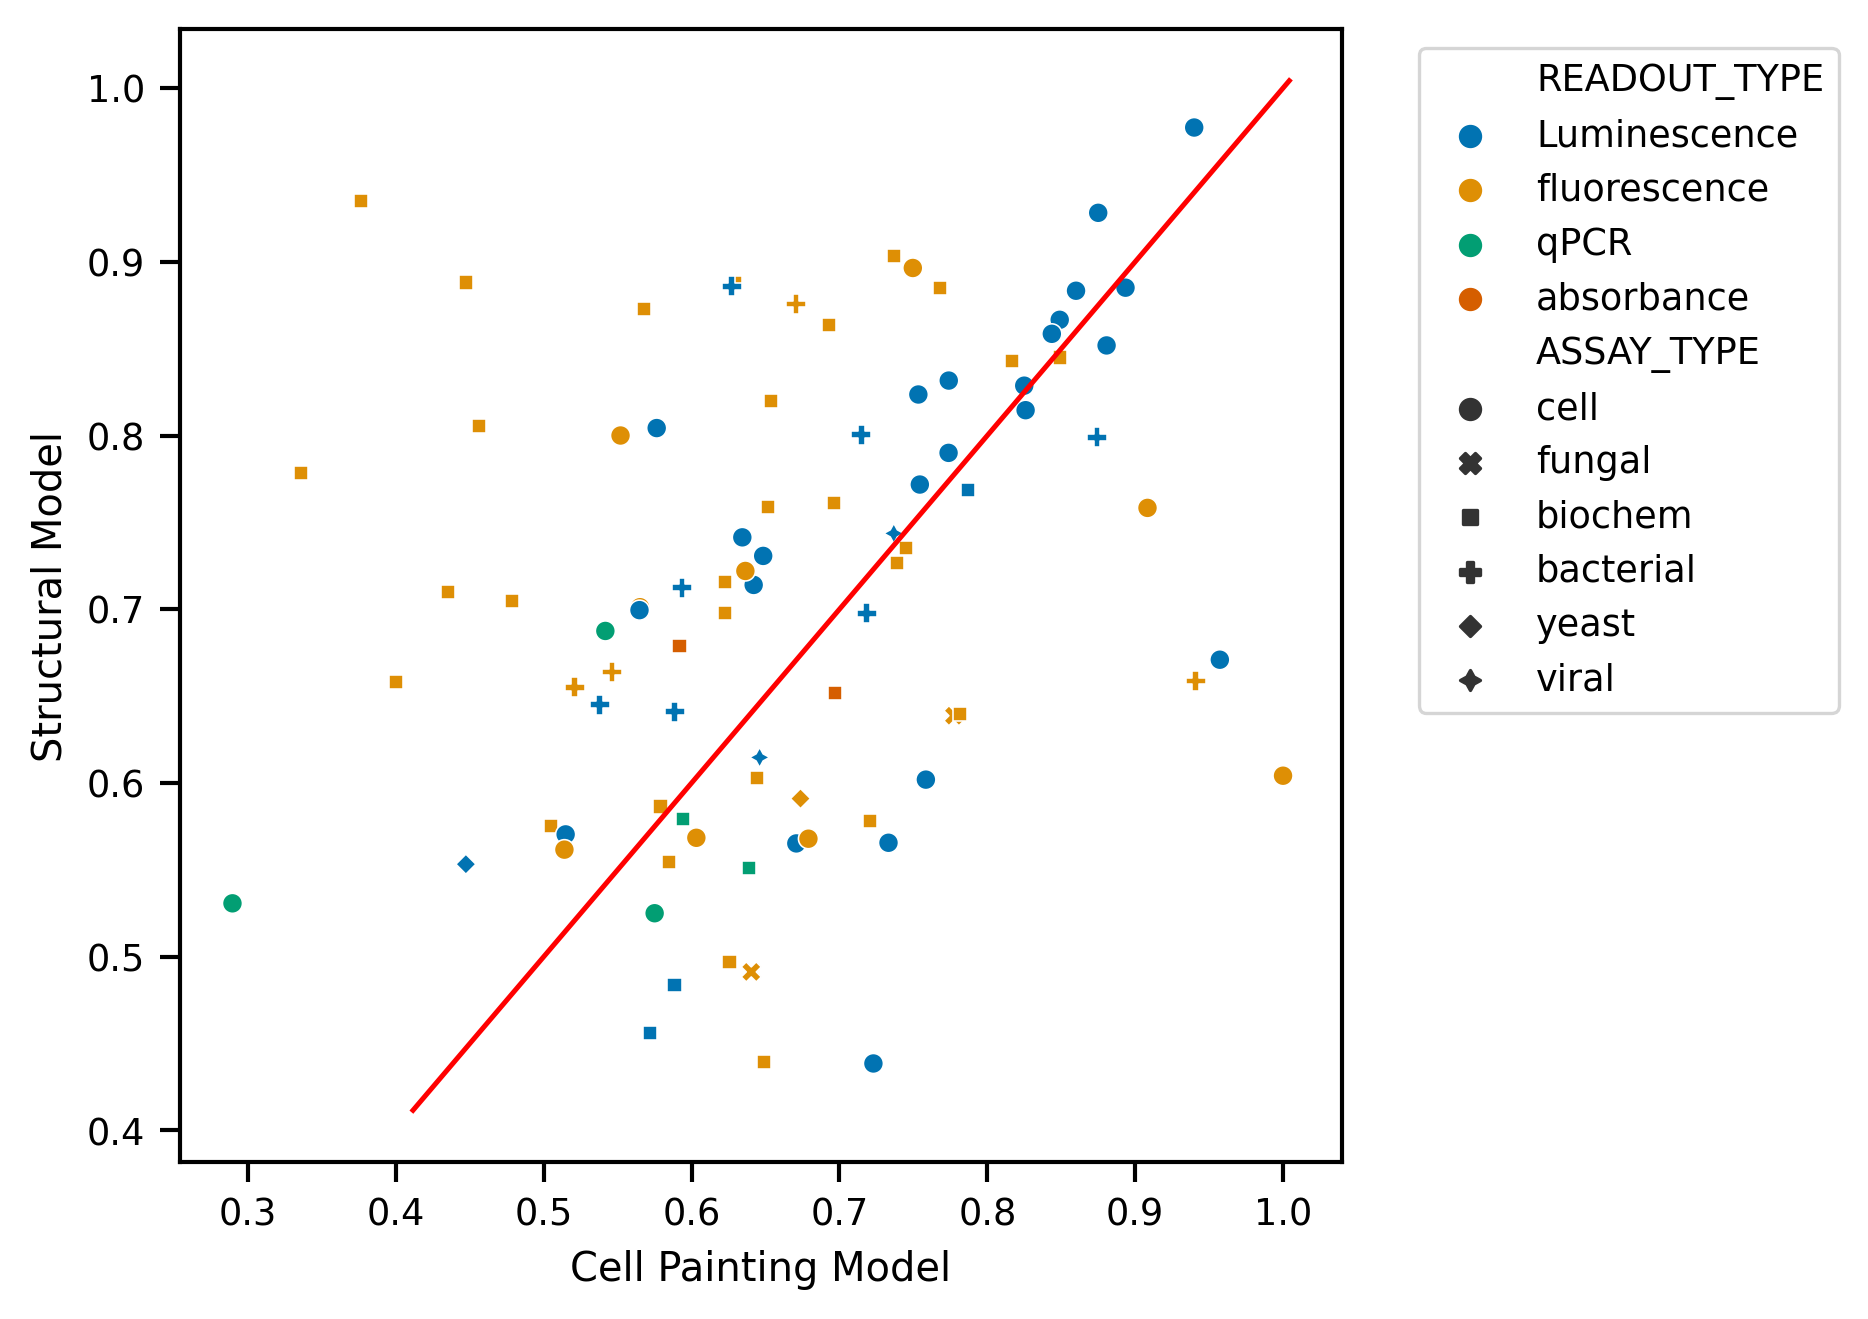

In [15]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
sns.set_context("paper")
g = sns.scatterplot(data=df_AUC, x="Cell Painting Model", y="Structural Model", 
                    hue="READOUT_TYPE", style="ASSAY_TYPE", palette="colorblind")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '-r')
plt.show()

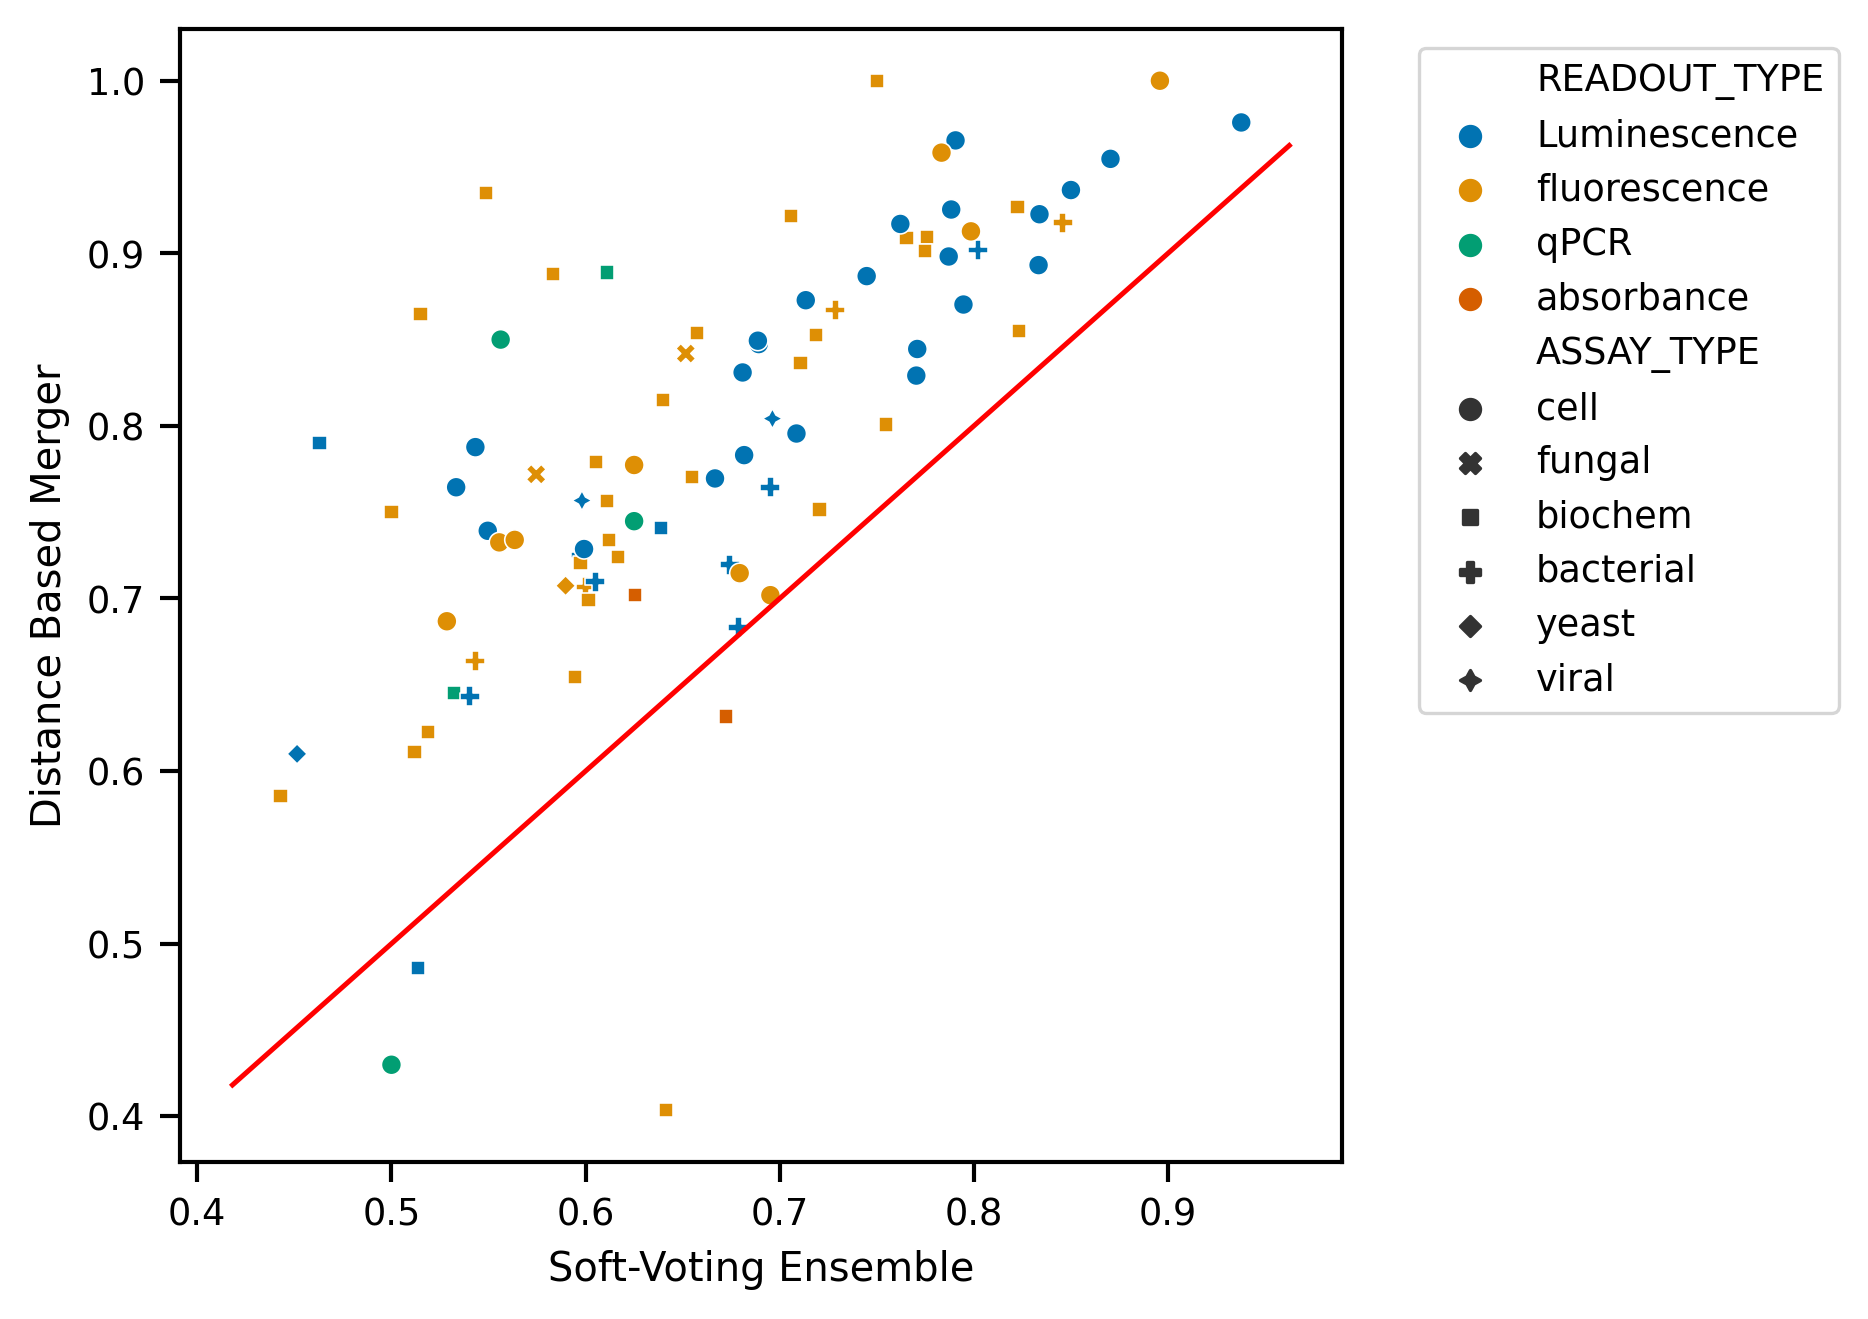

In [16]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
sns.set_context("paper")
g = sns.scatterplot(data=df_AUC, x="Soft-Voting Ensemble", y="Distance Based Merger", 
                    hue="READOUT_TYPE", style="ASSAY_TYPE", palette="colorblind"
                   )
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '-r')
plt.show()

In [20]:
df_AUC[df_AUC["ASSAY_TYPE"]=="cell"]["Cell Painting Model"].mean()

0.7190257073655757

In [24]:
df_AUC[df_AUC["ASSAY_TYPE"]=="cell"]["Distance Based Merger"].mean()

0.828651646479486

In [22]:
df_AUC[df_AUC["READOUT_TYPE"]=="Luminescence"]["Cell Painting Model"].mean()

0.721702292453144

In [23]:
df_AUC[df_AUC["ASSAY_TYPE"]=="biochem"]["Structural Model"].mean()

0.7066147166799982

In [25]:
df_AUC[df_AUC["ASSAY_TYPE"]=="biochem"]["Distance Based Merger"].mean()

0.7699315246735483

<Figure size 1000x400 with 0 Axes>

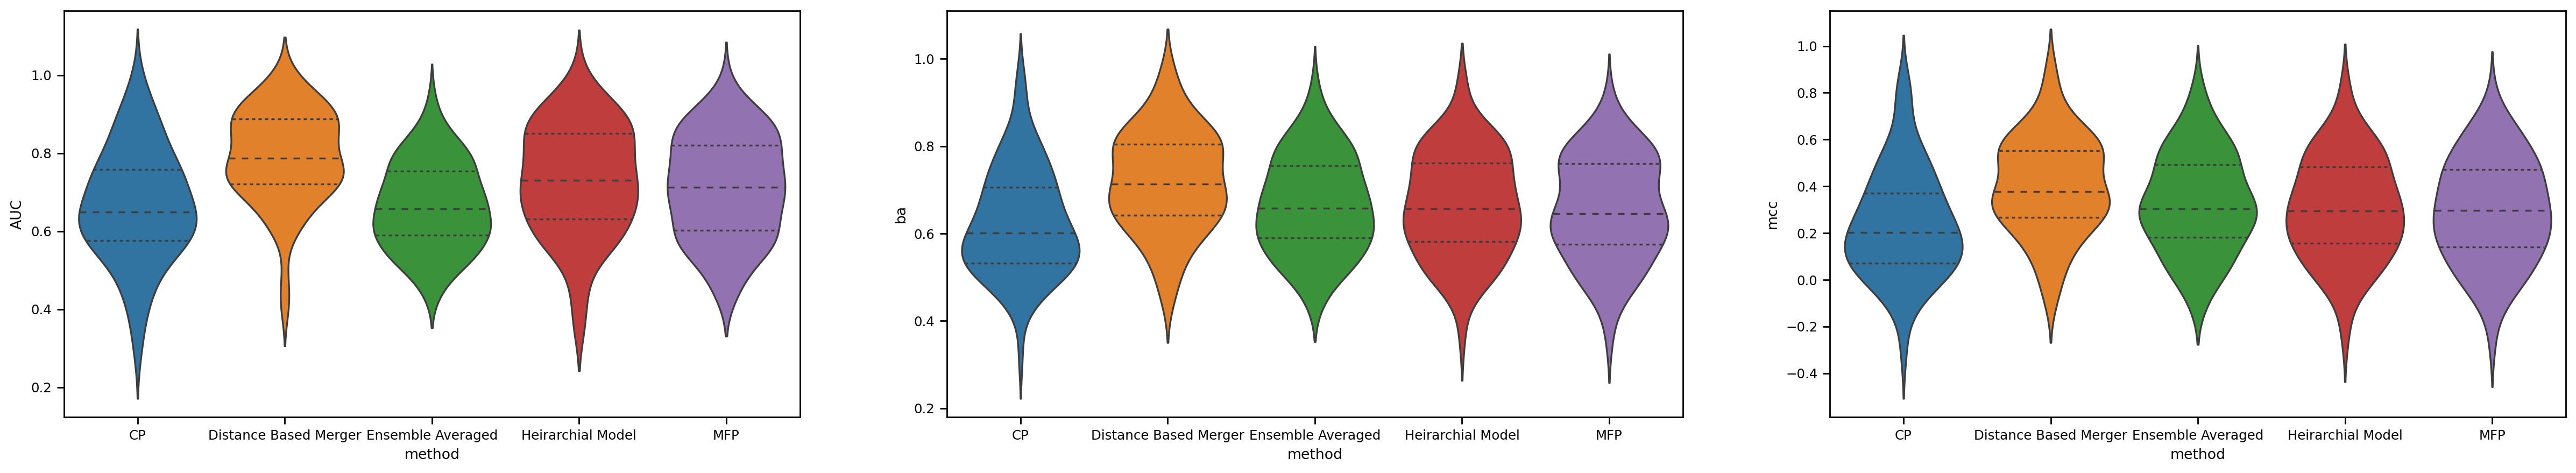

In [116]:
# Draw Plot
plt.figure(figsize=(10,4), dpi= 100)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 5), dpi=200)

sns.violinplot(x='method', y='AUC', data=metrics_list, scale='width', inner='quartile', ax=ax[0])
sns.violinplot(x='method', y='ba', data=metrics_list, scale='width', inner='quartile', ax=ax[1])
sns.violinplot(x='method', y='mcc', data=metrics_list, scale='width', inner='quartile', ax=ax[2])
#sns.violinplot(x='method', y='f1', data=metrics_list, scale='width', inner='quartile', ax=ax[1,1])
#sns.violinplot(x='method', y='precision', data=ba_df, scale='width', inner='quartile', ax=ax[2,0])
#sns.violinplot(x='method', y='Sensitivity', data=ba_df, scale='width', inner='quartile', ax=ax[2,1])
#sns.violinplot(x='method', y='Specificity', data=ba_df, scale='width', inner='quartile', ax=ax[3,0])

# Decoration
#plt.title('Performance over 92 assays', fontsize=15)
plt.show()

In [132]:
metrics_list

,assay,method,f1,precision,Sensitivity,Specificity,ba,mcc,AUC,ASSAY_NAME,OBS_NAME,OBS_SOURCE,ASSAY_TYPE,READOUT_TYPE
0,178_684,CP,0.606061,0.526316,0.714286,0.780488,0.747387,0.453246,0.754355,178_684,178_684,178_684,cell,Luminescence
1,178_684,Distance Based Merger,0.727273,0.631579,0.857143,0.829268,0.843206,0.628800,0.872822,178_684,178_684,178_684,cell,Luminescence
2,178_684,Ensemble Averaged,0.583333,0.700000,0.500000,0.926829,0.713415,0.482063,0.713415,178_684,178_684,178_684,cell,Luminescence
3,178_684,Heirarchial Model,0.620690,0.600000,0.642857,0.853659,0.748258,0.485639,0.789199,178_684,178_684,178_684,cell,Luminescence
4,178_684,MFP,0.434783,0.555556,0.357143,0.902439,0.629791,0.305654,0.771777,178_684,178_684,178_684,cell,Luminescence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,93_259,CP,0.470588,0.400000,0.571429,0.684211,0.627820,0.233074,0.578947,HoxA13DNABinding.FluorOligo.HoxDNA,HoxA13,ChemBank,biochem,fluorescence
441,93_259,Distance Based Merger,0.400000,0.666667,0.285714,0.947368,0.616541,0.323602,0.699248,HoxA13DNABinding.FluorOligo.HoxDNA,HoxA13,ChemBank,biochem,fluorescence
442,93_259,Ensemble Averaged,0.444444,0.363636,0.571429,0.631579,0.601504,0.182262,0.601504,HoxA13DNABinding.FluorOligo.HoxDNA,HoxA13,ChemBank,biochem,fluorescence
443,93_259,Heirarchial Model,0.400000,0.277778,0.714286,0.315789,0.515038,0.028904,0.586466,HoxA13DNABinding.FluorOligo.HoxDNA,HoxA13,ChemBank,biochem,fluorescence


In [138]:
metrics_list["ASSAY_TYPE"].unique()

array(['cell', 'fungal', 'biochem', 'bacterial', 'yeast', 'viral'],
      dtype=object)

In [234]:
# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls

pairs = [('cell', 'biochem')]


0
CP
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cell vs. biochem: t-test independent samples, P_val:3.837e-03 t=2.991e+00
1
MFP
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cell vs. biochem: t-test independent samples, P_val:5.511e-01 t=5.989e-01
2
Distance Based Merger
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

cell vs. biochem: t-test independent samples, P_val:4.497e-02 t=2.042e+00


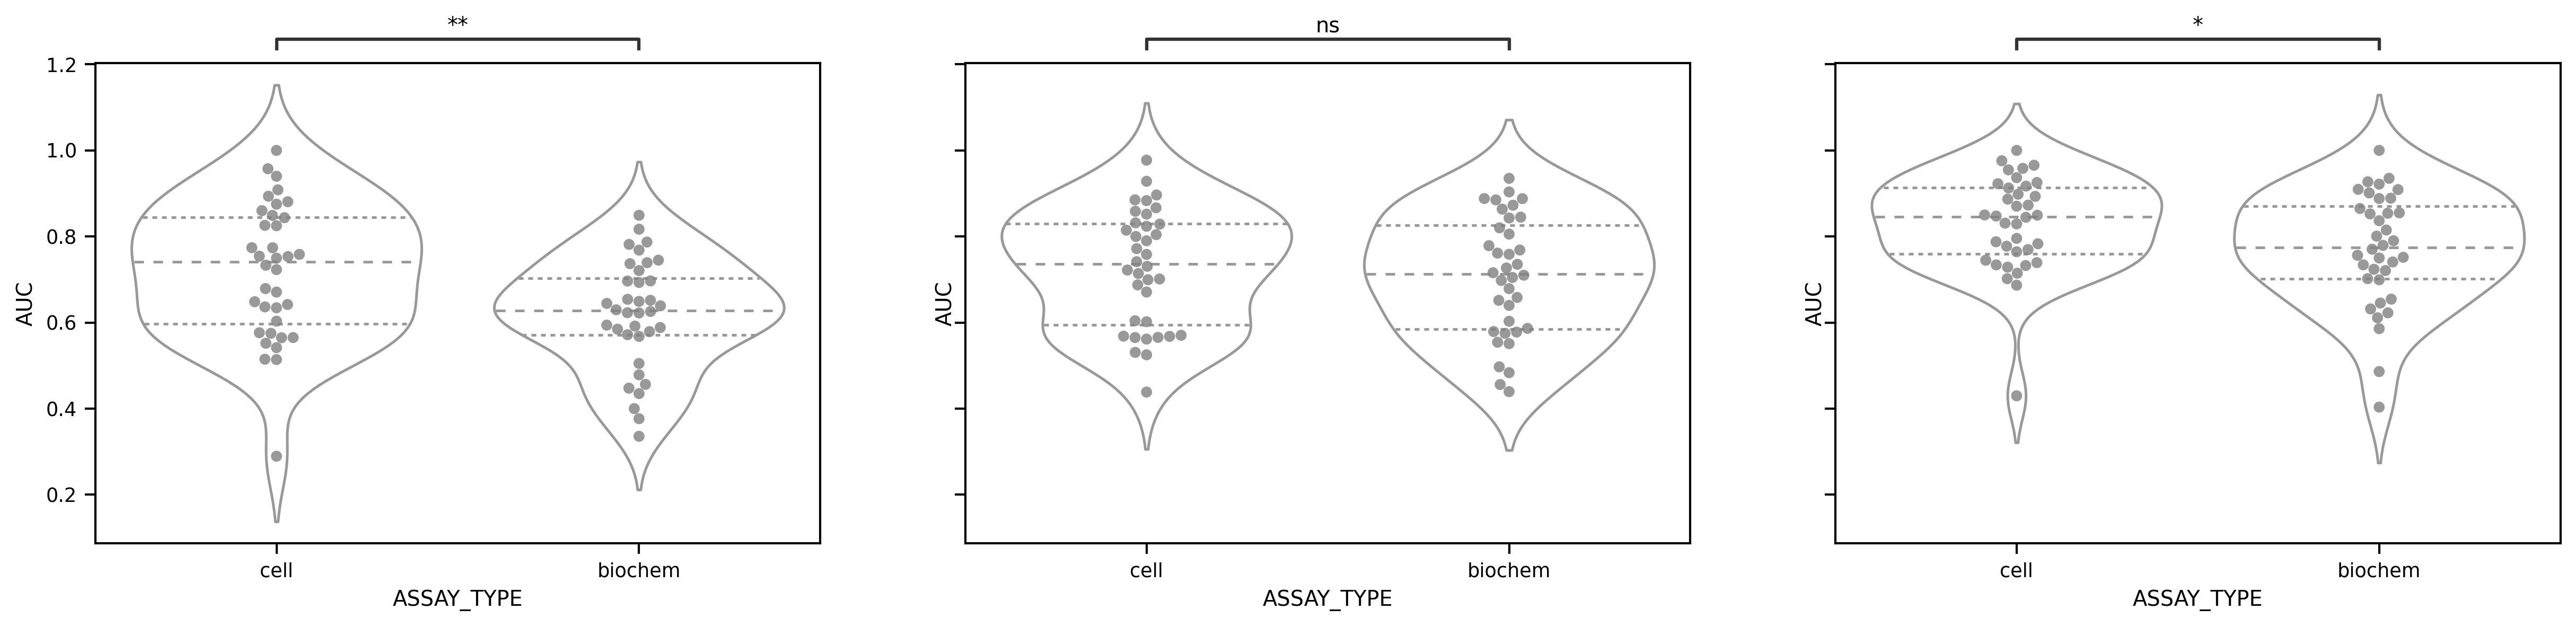

In [235]:
from statannotations.Annotator import Annotator

my_order=['cell', 'biochem']
         

fig, ax = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(20, 4), dpi=300)

for i, method in enumerate(['CP', 'MFP', 'Distance Based Merger']):
    print(i)
    print(method)

    sns.violinplot(ax= ax[i], x="ASSAY_TYPE", y='AUC', data=metrics_list[metrics_list["method"]==method], order=my_order, scale='width', inner='quartile', color="white")
    sns.swarmplot(ax= ax[i],x='ASSAY_TYPE', y='AUC', data=metrics_list[metrics_list["method"]==method], order=my_order,color="grey", alpha=0.8)
    annotator = Annotator(ax[i], pairs, data=metrics_list[metrics_list["method"]==method], x="ASSAY_TYPE", y='AUC', order=my_order)
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
plt.show()




In [251]:
k = metrics_list[metrics_list["method"]=="CP"]
k = k[k["ASSAY_TYPE"]=="cell"]
a = k.AUC.mean()
a

0.7190257073655757

In [252]:
k = metrics_list[metrics_list["method"]=="CP"]
k = k[k["ASSAY_TYPE"]=="biochem"]
b = k.AUC.mean()
b

0.6189481528813949

In [253]:
(a-b)/b *100

16.168972153529957

In [229]:
# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls

pairs = [('fluorescence', 'Luminescence')]


0
CP
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

fluorescence vs. Luminescence: t-test independent samples, P_val:9.064e-03 t=-2.675e+00
1
MFP
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

fluorescence vs. Luminescence: t-test independent samples, P_val:5.304e-01 t=-6.301e-01
2
Distance Based Merger
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

fluorescence vs. Luminescence: t-test independent samples, P_val:4.510e-01 t=-7.575e-01


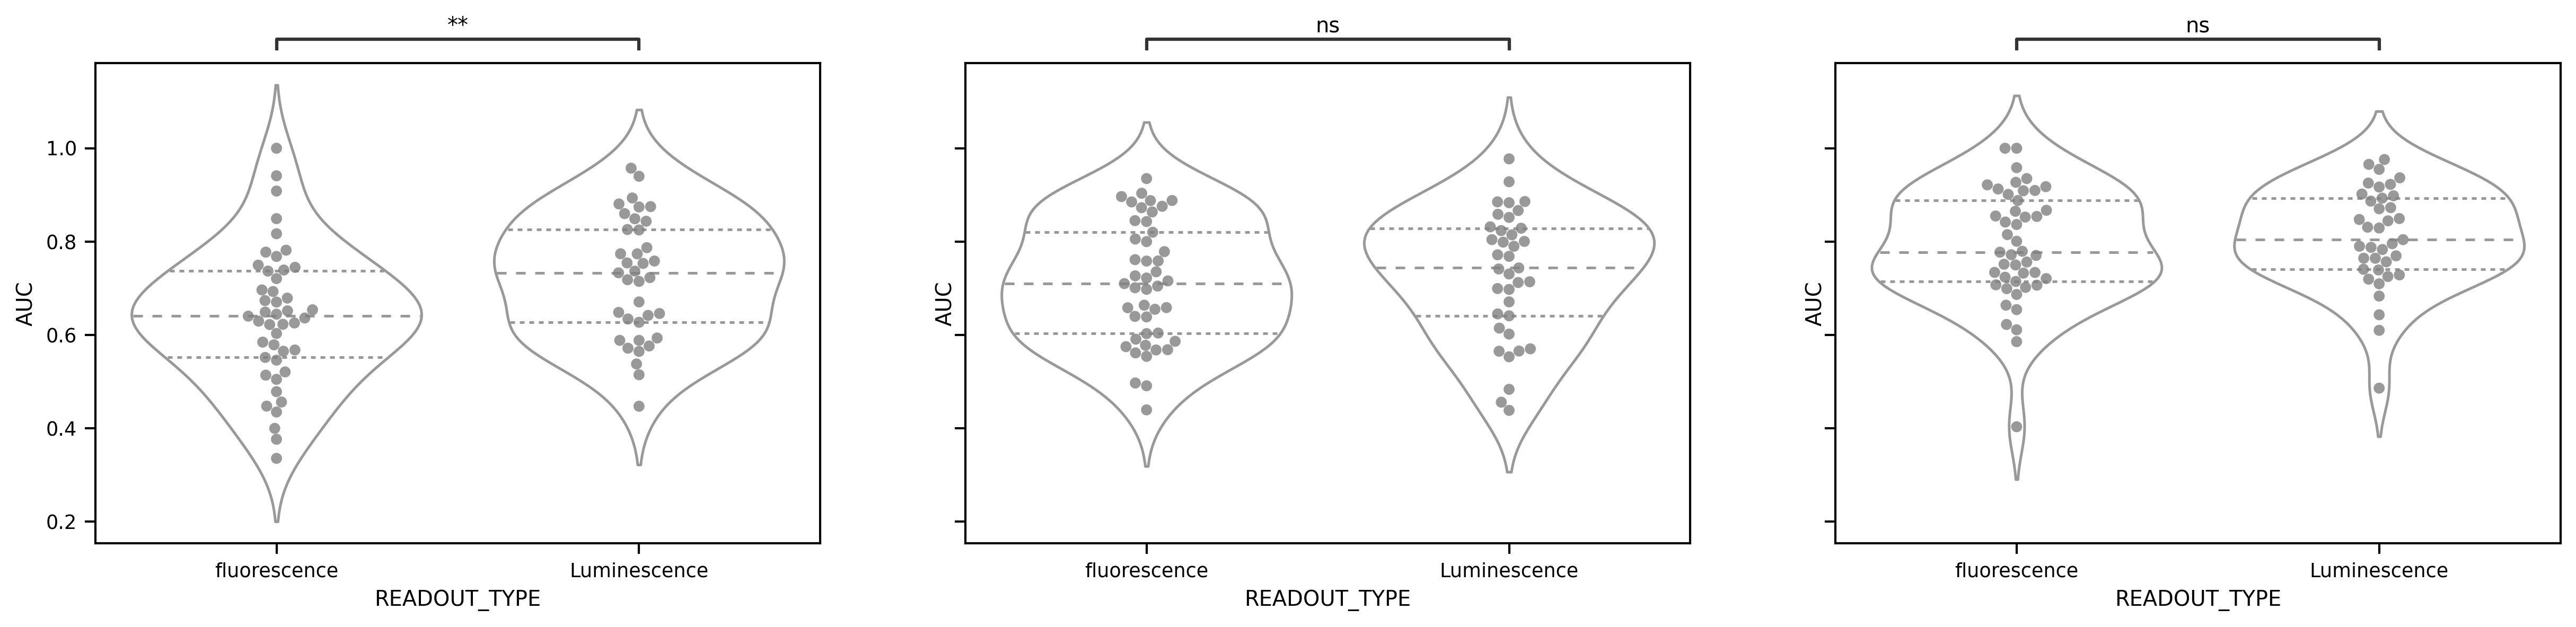

In [233]:
from statannotations.Annotator import Annotator

my_order=['fluorescence', 'Luminescence']
         

fig, ax = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(20, 4), dpi=300)

for i, method in enumerate(['CP', 'MFP', 'Distance Based Merger']):
    print(i)
    print(method)

    sns.violinplot(ax= ax[i], x="READOUT_TYPE", y='AUC', data=metrics_list[metrics_list["method"]==method], order=my_order, scale='width', inner='quartile', color="white")
    sns.swarmplot(ax= ax[i],x='READOUT_TYPE', y='AUC', data=metrics_list[metrics_list["method"]==method], order=my_order,color="grey", alpha=0.8)
    annotator = Annotator(ax[i], pairs, data=metrics_list[metrics_list["method"]==method], x="READOUT_TYPE", y='AUC', order=my_order)
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
plt.show()




In [248]:
k = metrics_list[metrics_list["method"]=="CP"]
k = k[k["READOUT_TYPE"]=="Luminescence"]
a = k.AUC.mean()
a

0.721702292453144

In [249]:
k = metrics_list[metrics_list["method"]=="CP"]
k = k[k["READOUT_TYPE"]=="fluorescence"]
b = k.AUC.mean()
b

0.639795262340344

In [250]:
(a-b)/b *100

12.802068870155045

In [267]:
# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls

pairs = [('Distance Based Merger', 'CP'),
         ('CP', 'MFP'),
         ('MFP', 'Distance Based Merger'),
        ('Ensemble Averaged', 'Distance Based Merger'),
        ('Heirarchial Model', 'Distance Based Merger')]


0
Luminescence
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CP vs. MFP: t-test paired samples, P_val:6.606e-01 t=-4.428e-01
Heirarchial Model vs. Distance Based Merger: t-test paired samples, P_val:1.614e-03 t=-3.411e+00
Ensemble Averaged vs. Distance Based Merger: t-test paired samples, P_val:5.998e-13 t=-1.089e+01
MFP vs. Distance Based Merger: t-test paired samples, P_val:2.014e-05 t=-4.904e+00
CP vs. Distance Based Merger: t-test paired samples, P_val:2.976e-08 t=-7.032e+00
1
fluorescence
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CP vs. MFP: t-test paired samples, P_val:1.787e-02 t=-2.460e+00
Heirarchial Model vs. Distance Based Merger: t-test paired samples, P_val:1.044e-03 t=-3.511e+00
Ensemble Averaged vs. Di

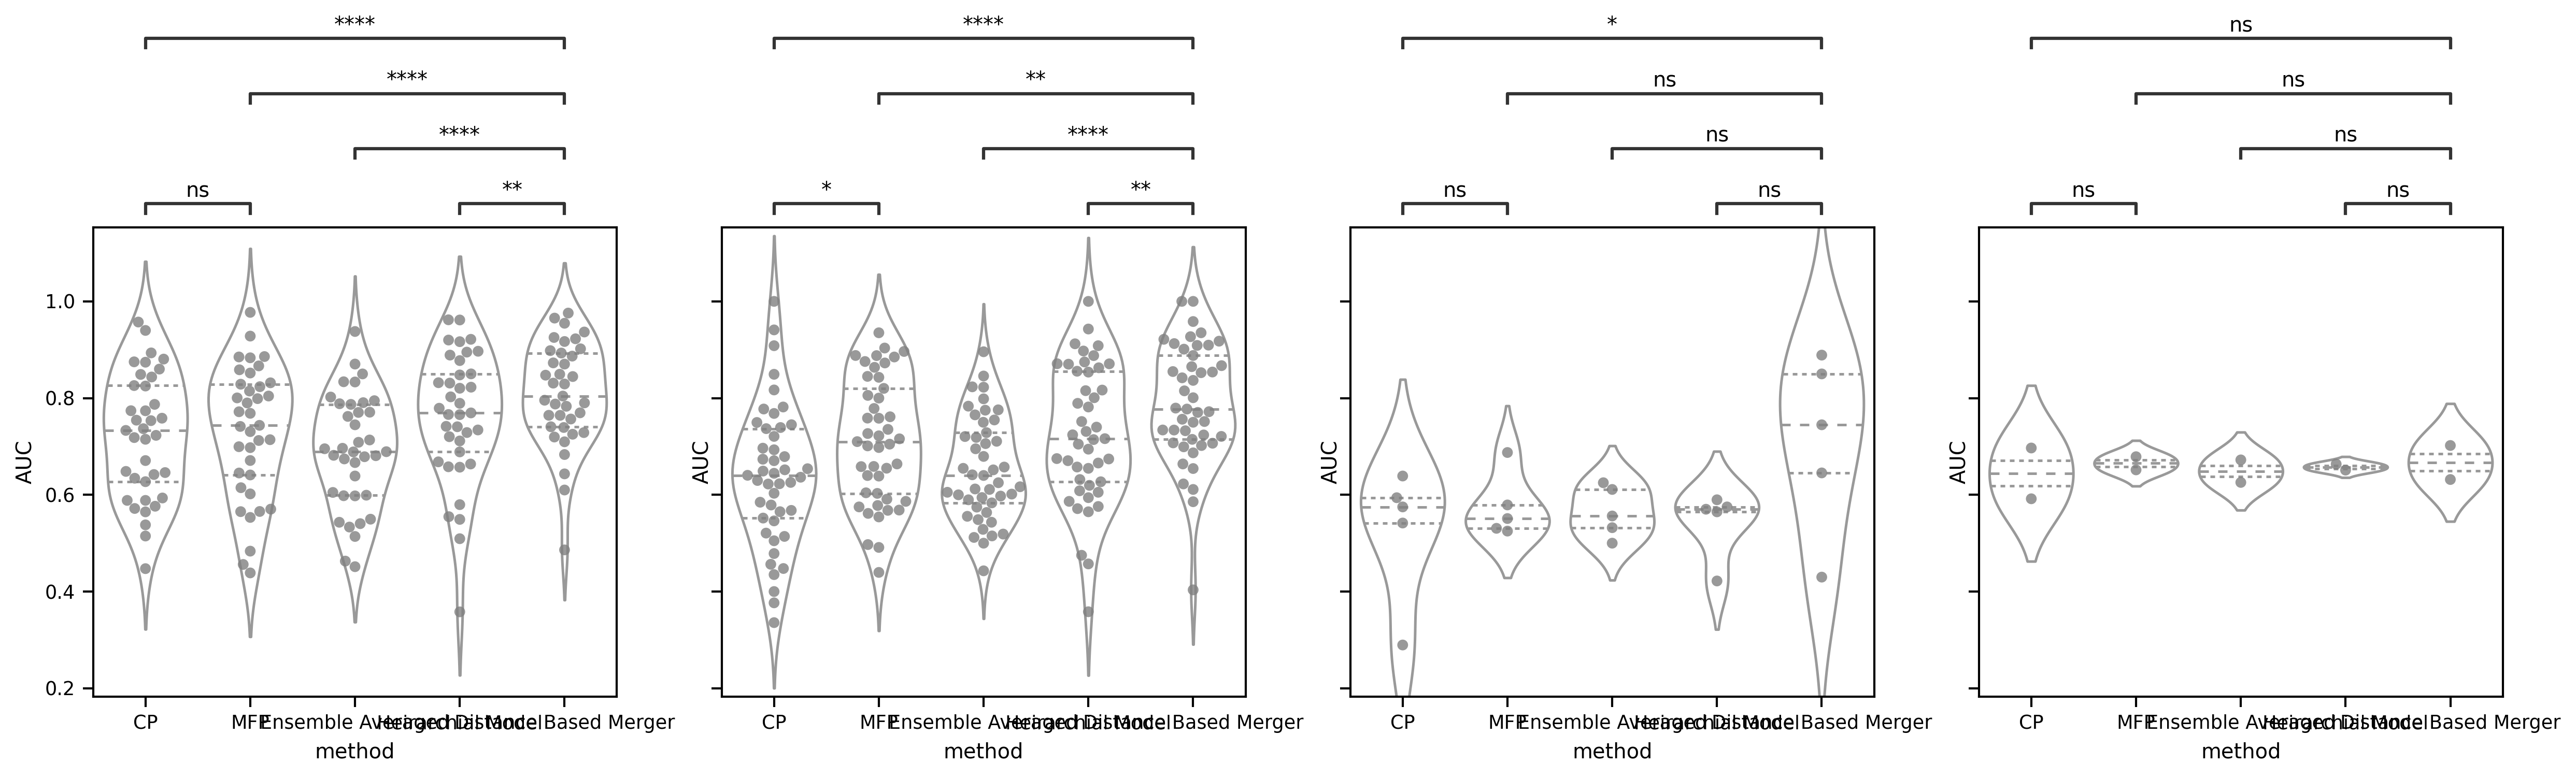

In [268]:
from statannotations.Annotator import Annotator

my_order=['CP', 'MFP', 'Ensemble Averaged', 'Heirarchial Model', 'Distance Based Merger']

fig, ax = plt.subplots(1, 4, sharex='all', sharey='all', figsize=(20, 4), dpi=300)

for i, readout_type in enumerate(['Luminescence', 'fluorescence', 'qPCR', 'absorbance']):
    print(i)
    print(readout_type)

    sns.violinplot(ax= ax[i], x="method", y='AUC', data=metrics_list[metrics_list["READOUT_TYPE"]==readout_type], order=my_order, scale='width', inner='quartile', color="white")
    sns.swarmplot(ax= ax[i],x='method', y='AUC', data=metrics_list[metrics_list["READOUT_TYPE"]==readout_type], order=my_order,color="grey", alpha=0.8)
    annotator = Annotator(ax[i], pairs, data=metrics_list[metrics_list["READOUT_TYPE"]==readout_type], x="method", y='AUC', order=my_order)
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
plt.show()




0
absorbance
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CP vs. MFP: t-test paired samples, P_val:7.719e-01 t=-2.922e-01
Heirarchial Model vs. Distance Based Merger: t-test paired samples, P_val:4.634e-04 t=-3.863e+00
Ensemble Averaged vs. Distance Based Merger: t-test paired samples, P_val:1.106e-12 t=-1.079e+01
MFP vs. Distance Based Merger: t-test paired samples, P_val:2.735e-06 t=-5.583e+00
CP vs. Distance Based Merger: t-test paired samples, P_val:5.189e-10 t=-8.485e+00
1
absorbance
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CP vs. MFP: t-test paired samples, P_val:2.302e-02 t=2.764e+01
Heirarchial Model vs. Distance Based Merger: t-test paired samples, P_val:3.475e-02 t=-1.830e+01
Ensemble Averaged vs. Distanc

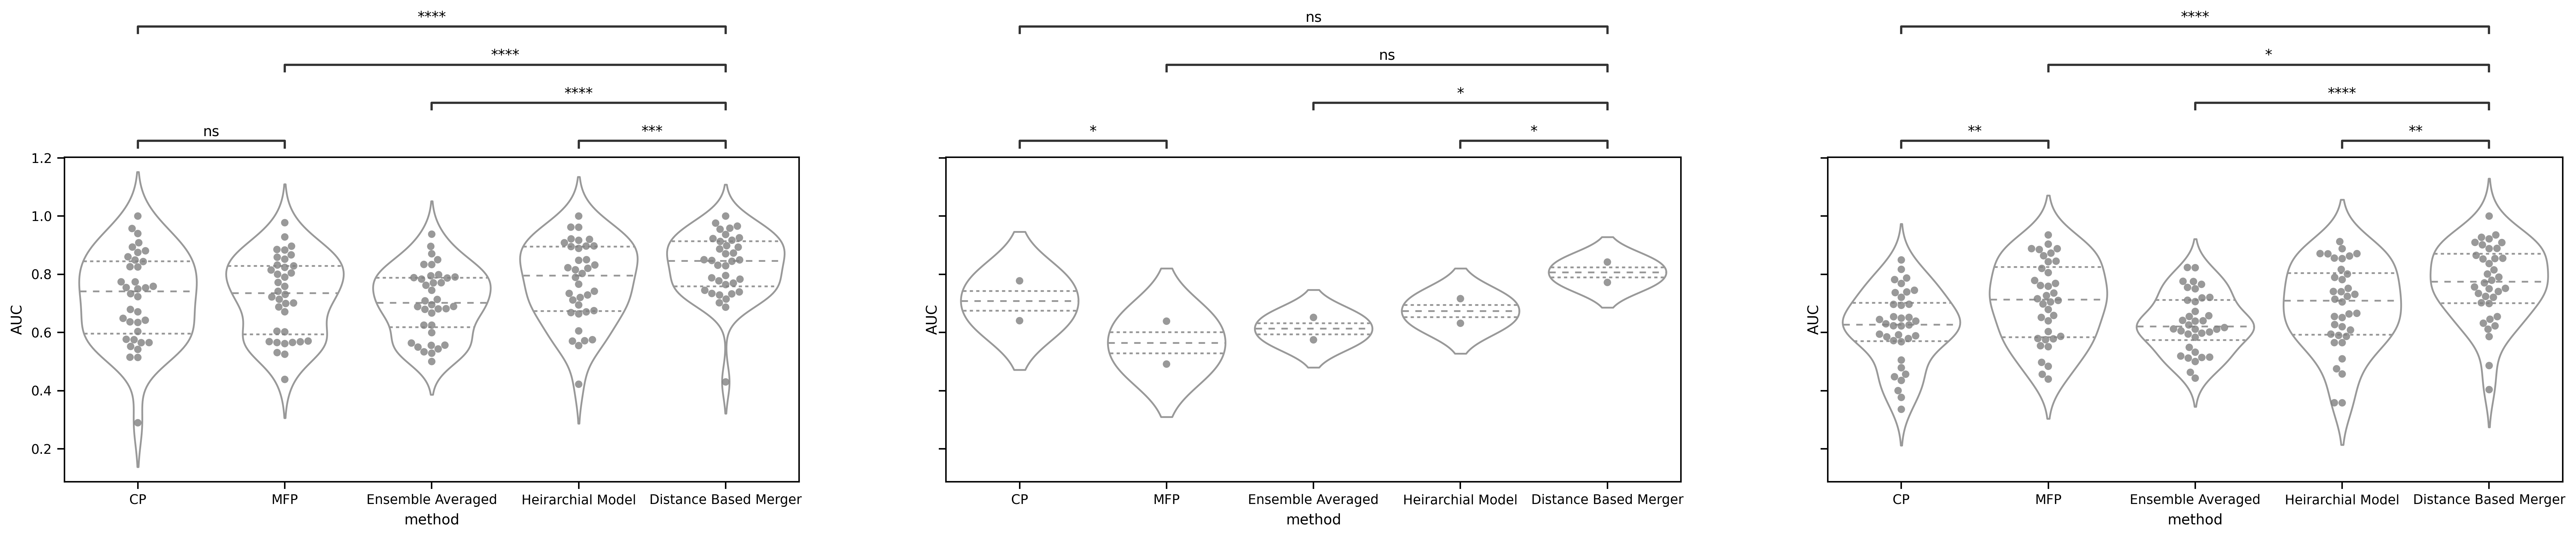

In [212]:
from statannotations.Annotator import Annotator

my_order=['CP', 'MFP', 'Ensemble Averaged', 'Heirarchial Model', 'Distance Based Merger']

fig, ax = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(30, 4), dpi=300)

for i, assay_type in enumerate(['cell', 'fungal', 'biochem']):
    print(i)
    print(readout_type)

    sns.violinplot(ax= ax[i], x="method", y='AUC', data=metrics_list[metrics_list["ASSAY_TYPE"]==assay_type], order=my_order, scale='width', inner='quartile', color="white")
    sns.swarmplot(ax= ax[i],x='method', y='AUC', data=metrics_list[metrics_list["ASSAY_TYPE"]==assay_type], order=my_order,color="grey", alpha=0.8)
    annotator = Annotator(ax[i], pairs, data=metrics_list[metrics_list["ASSAY_TYPE"]==assay_type], x="method", y='AUC', order=my_order)
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
plt.show()




0
absorbance
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CP vs. MFP: t-test paired samples, P_val:1.822e-01 t=-1.434e+00
Heirarchial Model vs. Distance Based Merger: t-test paired samples, P_val:7.251e-01 t=-3.617e-01
Ensemble Averaged vs. Distance Based Merger: t-test paired samples, P_val:1.858e-05 t=-7.591e+00
MFP vs. Distance Based Merger: t-test paired samples, P_val:4.570e-01 t=-7.737e-01
CP vs. Distance Based Merger: t-test paired samples, P_val:1.740e-03 t=-4.231e+00
1
absorbance
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CP vs. MFP: t-test paired samples, P_val:9.219e-01 t=-1.234e-01
Heirarchial Model vs. Distance Based Merger: t-test paired samples, P_val:1.812e-01 t=-3.417e+00
Ensemble Averaged vs. Distan

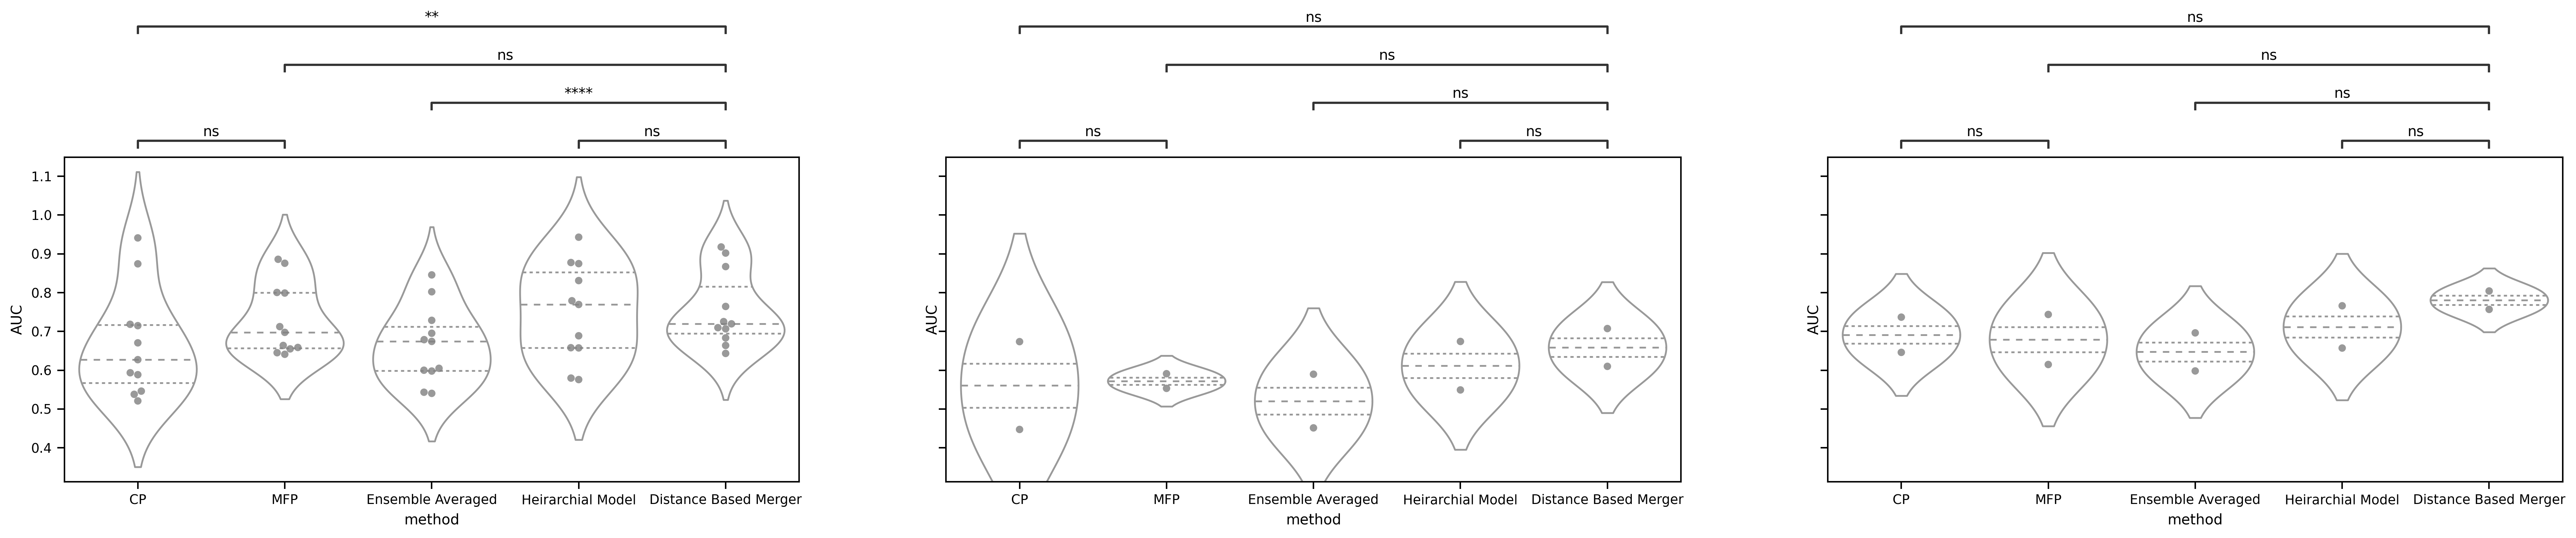

In [214]:
from statannotations.Annotator import Annotator

my_order=['CP', 'MFP', 'Ensemble Averaged', 'Heirarchial Model', 'Distance Based Merger']

fig, ax = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(30, 4), dpi=300)

for i, assay_type in enumerate([ 'bacterial', 'yeast', 'viral']):
    print(i)
    print(readout_type)

    sns.violinplot(ax= ax[i], x="method", y='AUC', data=metrics_list[metrics_list["ASSAY_TYPE"]==assay_type], order=my_order, scale='width', inner='quartile', color="white")
    sns.swarmplot(ax= ax[i],x='method', y='AUC', data=metrics_list[metrics_list["ASSAY_TYPE"]==assay_type], order=my_order,color="grey", alpha=0.8)
    annotator = Annotator(ax[i], pairs, data=metrics_list[metrics_list["ASSAY_TYPE"]==assay_type], x="method", y='AUC', order=my_order)
    annotator.configure(test='t-test_paired', text_format='star', loc='outside')
    annotator.apply_and_annotate()
    
plt.show()


